# <center> Prediction du prix de vente de maison et appartement en Ile de France </center>

## Importer les librairies nécessaires

In [1]:
import pandas as pd
import pickle
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

## Récupérer les données scrapper de seloger.com

In [2]:
data = pd.read_csv("./seloger-cleaned.csv")
data.head()

,id,type_of_logement_raw,ville_raw,quartier_raw,room_nb_raw,bedroom_nb_raw,surface_raw,price_raw
0,0,Maison,Triel sur Seine,Nord et Ouest,8.0,4.0,230.00,630000.0
1,1,Appartement,Verneuil sur Seine,Clairieres,4.0,2.0,75.49,170000.0
2,2,Appartement,Meaux,Croix Saint Loup-Saint Nicolas,4.0,3.0,100.18,409500.0
3,3,Appartement,Carrières-sous-Poissy,Apollinaire,2.0,1.0,31.00,129000.0
4,4,Appartement,NaN,NaN,3.0,2.0,64.00,129000.0


## Nettoyage des données

Enlever la colonne id

In [3]:
data = data.drop(['id'], axis=1)
data.head()

,type_of_logement_raw,ville_raw,quartier_raw,room_nb_raw,bedroom_nb_raw,surface_raw,price_raw
0,Maison,Triel sur Seine,Nord et Ouest,8.0,4.0,230.00,630000.0
1,Appartement,Verneuil sur Seine,Clairieres,4.0,2.0,75.49,170000.0
2,Appartement,Meaux,Croix Saint Loup-Saint Nicolas,4.0,3.0,100.18,409500.0
3,Appartement,Carrières-sous-Poissy,Apollinaire,2.0,1.0,31.00,129000.0
4,Appartement,NaN,NaN,3.0,2.0,64.00,129000.0


Enlever les na lorsqu'il y en a trop et les remplacer pour les autres

In [4]:
data.isnull().sum()

type_of_logement_raw      0
ville_raw               991
quartier_raw            991
room_nb_raw             175
bedroom_nb_raw          453
surface_raw             188
price_raw                 7
dtype: int64

In [5]:
data.dropna(subset=['price_raw'],inplace=True)
data.dropna(subset=['ville_raw'],inplace=True)
data.dropna(subset=['quartier_raw'],inplace=True)
data.shape

(4001, 7)

In [6]:
data["room_nb_raw"] = data["room_nb_raw"].fillna(0)
data["bedroom_nb_raw"] = data["bedroom_nb_raw"].fillna(0)
data["surface_raw"] = data["surface_raw"].fillna(0)
data

,type_of_logement_raw,ville_raw,quartier_raw,room_nb_raw,bedroom_nb_raw,surface_raw,price_raw
0,Maison,Triel sur Seine,Nord et Ouest,8.0,4.0,230.00,630000.0
1,Appartement,Verneuil sur Seine,Clairieres,4.0,2.0,75.49,170000.0
2,Appartement,Meaux,Croix Saint Loup-Saint Nicolas,4.0,3.0,100.18,409500.0
3,Appartement,Carrières-sous-Poissy,Apollinaire,2.0,1.0,31.00,129000.0
6,Maison,Sannois,Gabriel Peri,7.0,4.0,185.00,599000.0
8,Maison,Saint-Maur-des-Fossés,Champignol,6.0,4.0,170.00,1238000.0
11,Appartement,Poissy,Mairie,3.0,2.0,51.72,219000.0
12,Maison,Poissy,Gare,5.0,2.0,115.00,832000.0
15,Maison,Noisy-le-Grand,Varenne-Centre-Rive Charmante,10.0,6.0,350.00,1590000.0
17,Appartement,Carrières-sous-Poissy,Le Village,2.0,1.0,29.98,129000.0


## Label encoding des features catégorielle

In [7]:
df = data.iloc[ : , :-1].values
df

array([['Maison', 'Triel sur Seine', 'Nord et Ouest', 8.0, 4.0, 230.0],
       ['Appartement', 'Verneuil sur Seine', 'Clairieres', 4.0, 2.0,
        75.49],
       ['Appartement', 'Meaux', 'Croix Saint Loup-Saint Nicolas', 4.0,
        3.0, 100.18],
       ...,
       ['Appartement', 'Gagny', 'Gare de Gagny-Henri Barbusse', 0.0, 0.0,
        0.0],
       ['Appartement', 'Chevilly Larue', 'La Guinet', 3.0, 2.0, 62.0],
       ['Appartement', 'Puteaux', 'Bergère-Moulin', 4.0, 3.0, 87.0]],
      dtype=object)

In [8]:
label_encoder = LabelEncoder()

In [9]:
df[ : ,0] = label_encoder.fit_transform(df[ : ,0])
df

array([[1, 'Triel sur Seine', 'Nord et Ouest', 8.0, 4.0, 230.0],
       [0, 'Verneuil sur Seine', 'Clairieres', 4.0, 2.0, 75.49],
       [0, 'Meaux', 'Croix Saint Loup-Saint Nicolas', 4.0, 3.0, 100.18],
       ...,
       [0, 'Gagny', 'Gare de Gagny-Henri Barbusse', 0.0, 0.0, 0.0],
       [0, 'Chevilly Larue', 'La Guinet', 3.0, 2.0, 62.0],
       [0, 'Puteaux', 'Bergère-Moulin', 4.0, 3.0, 87.0]], dtype=object)

In [10]:
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
mapping

{'Appartement': 0, 'Maison': 1}

In [11]:
df[ : ,1] = label_encoder.fit_transform(df[ : ,1])
df

array([[1, 275, 'Nord et Ouest', 8.0, 4.0, 230.0],
       [0, 281, 'Clairieres', 4.0, 2.0, 75.49],
       [0, 161, 'Croix Saint Loup-Saint Nicolas', 4.0, 3.0, 100.18],
       ...,
       [0, 92, 'Gare de Gagny-Henri Barbusse', 0.0, 0.0, 0.0],
       [0, 45, 'La Guinet', 3.0, 2.0, 62.0],
       [0, 228, 'Bergère-Moulin', 4.0, 3.0, 87.0]], dtype=object)

In [12]:
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
mapping

{'Achères': 0,
 'Alfortville': 1,
 'Andrésy': 2,
 'Antony': 3,
 'Arcueil': 4,
 'Argenteuil': 5,
 'Arpajon': 6,
 'Asnières-sur-Seine': 7,
 'Athis-Mons': 8,
 'Aubergenville': 9,
 'Aubervilliers': 10,
 'Aulnay-sous-Bois': 11,
 'Auvers-sur-Oise': 12,
 'Bagnolet': 13,
 'Beauchamp': 14,
 'Bessancourt': 15,
 'Beynes': 16,
 'Bezons': 17,
 'Bois le Roi': 18,
 'Bois-Colombes': 19,
 "Bois-d'Arcy": 20,
 'Boissy-Saint-Léger': 21,
 'Bondoufle': 22,
 'Bondy': 23,
 'Bonneuil-sur-Marne': 24,
 'Bougival': 25,
 'Boulogne-Billancourt': 26,
 'Bourg-la-Reine': 27,
 'Brie-Comte-Robert': 28,
 'Brunoy': 29,
 'Bry-sur-Marne': 30,
 'Brétigny-sur-Orge': 31,
 'Bussy-Saint-Georges': 32,
 'Cachan': 33,
 'Carrières-sous-Poissy': 34,
 'Cergy': 35,
 'Chambourcy': 36,
 'Champigny-sur-Marne': 37,
 'Champs-sur-Marne': 38,
 'Chanteloup-les-Vignes': 39,
 'Charenton-le-Pont': 40,
 'Chatou': 41,
 'Chaville': 42,
 'Chelles': 43,
 'Chennevières-sur-Marne': 44,
 'Chevilly Larue': 45,
 'Chevreuse': 46,
 'Chilly-Mazarin': 47,
 'Ch

In [13]:
df[ : ,2] = label_encoder.fit_transform(df[ : ,2])
df

array([[1, 275, 729, 8.0, 4.0, 230.0],
       [0, 281, 220, 4.0, 2.0, 75.49],
       [0, 161, 253, 4.0, 3.0, 100.18],
       ...,
       [0, 92, 349, 0.0, 0.0, 0.0],
       [0, 45, 489, 3.0, 2.0, 62.0],
       [0, 228, 73, 4.0, 3.0, 87.0]], dtype=object)

In [14]:
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
mapping

{'A, Sisley': 0,
 'Adamville': 1,
 'Agent Sarre-Centre-Les Vallées-La Garenne': 2,
 'Agnettes': 3,
 'Aguado': 4,
 'Alfort': 5,
 'Aligre-Gare de Lyon': 6,
 'Allende': 7,
 'Alleray Procession': 8,
 'Alouettes': 9,
 'Alsace': 10,
 'Amandiers': 11,
 'Amiraux-Simplon-Poissonniers': 12,
 'Anatole France': 13,
 'Anatole France-Lepetit et Vergeat': 14,
 'Ancien Centre Ville': 15,
 'Anjou': 16,
 'Apollinaire': 17,
 'Arche Guedon': 18,
 'Archives': 19,
 'Aristide Briand': 20,
 'Aristide Briand-Champagne': 21,
 'Aristide Briand-Saint Hubert-Plateau': 22,
 'Armée Leclerc-Henri Dunant': 23,
 'Armée Leclerc-Jean Allemane': 24,
 'Arpents-Etang-Vignes': 25,
 'Arsenal': 26,
 'Artistes Lyriques-La Theuillerie': 27,
 'Arts et Métiers': 28,
 'Ascott-Village Ouest-Le Verger': 29,
 'Atlantis-Massy Sud': 30,
 'Aubert': 31,
 'Auguste Geneviève-Benoit Malon': 32,
 'Aunettes Ouest': 33,
 'Auteuil Nord': 34,
 'Auteuil Sud': 35,
 'Avenue Nationale': 36,
 'Avenue du Mantois': 37,
 'Bac-Bécon-Flachat-Colombes': 38,

## Préparer les données pour le modèle

Définir l'input et l'ouput

In [15]:
y = data.price_raw
X = df

Faire le split 80/20

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.2, random_state=42)

Enregistrer le split dans un nouveau répertoire créer selon la date du jour

In [17]:
nomfic = time.strftime("%Y-%m-%d")
if not os.path.exists(nomfic):
 os.makedirs(nomfic)

In [18]:
with open('C:/Users/utilisateur/Desktop/HousePricesAZ/app/' + nomfic +'/'+ nomfic+'_split.pkl', 'wb') as f:
    pickle.dump(train_test_split, f)

In [19]:
pd.DataFrame(X_train).to_csv("C:/Users/utilisateur/Desktop/HousePricesAZ/app/" + nomfic +"/"+ nomfic+"_X_train.csv", index = False)
pd.DataFrame(X_val).to_csv("C:/Users/utilisateur/Desktop/HousePricesAZ/app/" + nomfic +"/"+ nomfic+"_X_val.csv", index = False)
pd.DataFrame(y_train).to_csv("C:/Users/utilisateur/Desktop/HousePricesAZ/app/" + nomfic +"/"+ nomfic+"_y_train.csv", index = False)
pd.DataFrame(y_val).to_csv("C:/Users/utilisateur/Desktop/HousePricesAZ/app/" + nomfic +"/"+ nomfic+"_y_val.csv", index = False)

Standardiser les données

In [20]:
standard_x = StandardScaler()

In [21]:
X_train = standard_x.fit_transform(X_train)
X_val = standard_x.transform(X_val)

Enregistrer le scaler

In [22]:
with open('C:/Users/utilisateur/Desktop/HousePricesAZ/app/' + nomfic +'/'+ nomfic+'_scaler.sav', 'wb') as f:
    pickle.dump(standard_x, f)

In [23]:
print('Train_Shape: ',X_train.shape)
print("\nX_train:")
X_train

Train_Shape:  (3200, 6)

X_train:


array([[-0.62602678,  1.4474189 ,  1.31748428, -0.02883428,  0.31968171,
         0.15305282],
       [-0.62602678, -1.69830015, -1.06251256, -1.88350167, -1.60804717,
        -1.41079188],
       [-0.62602678,  0.94828266, -0.30024784, -0.49250113, -0.32289459,
        -0.39750158],
       ...,
       [-0.62602678,  0.64647936,  1.57046297, -0.49250113, -0.32289459,
        -0.54435524],
       [-0.62602678, -1.25720301, -1.2089739 , -0.49250113, -0.32289459,
        -0.48561378],
       [ 1.59737576, -0.95539971,  0.19239487,  0.43483257,  0.962258  ,
        -0.16253571]])

In [24]:
print('Val_Shape: ',X_val.shape)
print("\nX_val:")
X_val

Val_Shape:  (801, 6)

X_val:


array([[-0.62602678, -1.7911627 , -1.11244256, -0.02883428, -0.32289459,
        -0.25064791],
       [-0.62602678, -0.61877295, -0.96598122, -0.02883428, -0.32289459,
        -0.29470401],
       [-0.62602678, -1.44292812,  0.20570953, -0.49250113, -0.32289459,
        -0.33655731],
       ...,
       [ 1.59737576,  0.07769621, -0.83283454,  2.28949996,  1.60483429,
         1.23257412],
       [-0.62602678,  0.12412749, -1.1890019 , -0.49250113, -0.32289459,
        -0.67652354],
       [ 1.59737576,  0.3678917 ,  0.25231087,  0.89849941,  0.962258  ,
         0.63047409]])

## Lancer le modèle

Trouver les meilleurs hyperparamètres avec GridSearchCV

In [25]:
#import xgboost
#from sklearn.model_selection import GridSearchCV 

#for tuning parameters
#parameters_for_testing = {
#    'learning_rate':[0.1,0.07],
#     'max_depth':[3,5],
#     'n_estimators':[10000],
#     'reg_alpha':[1e-5, 1e-2,  0.75],
#     'reg_lambda':[1e-5, 1e-2, 0.45],
#     'subsample':[0.6,0.95],
#}

                    
#xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

#gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_absolute_error')
#gsearch1.fit(X_train,y_train)
#print (gsearch1.cv_results_)
#print('best params')
#print (gsearch1.best_params_)
#print('best score')
#print (gsearch1.best_score_)

Définir et fitter le modèle

In [26]:
import xgboost
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 objective ='reg:squarederror',                 
                 learning_rate=0.1,
                 max_depth=5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.01,
                 reg_lambda=1e-05,
                 subsample=0.95,
                 seed=42)

In [27]:
best_xgb_model.fit(X_train,y_train)

C:\Users\utilisateur\Anaconda3\envs\house_pricesAZ\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.01, reg_lambda=1e-05,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.95,
             verbosity=1)

Enregistrer le modèle

In [28]:
filename = 'house_model.pkl'

In [29]:
pickle.dump(best_xgb_model, open(filename, 'wb'))

In [30]:
loaded_model = pickle.load(open(filename, 'rb'))

Evaluer le modèle

In [31]:
predictions = loaded_model.predict(X_val)

In [32]:
predictions

array([ 2.57251281e+05,  6.04664562e+05,  2.08995047e+05,  3.02990906e+05,
        4.21093438e+05,  5.64804750e+05,  4.18100125e+05,  5.71214125e+05,
        3.42034000e+05,  3.83071906e+05,  1.62589281e+05,  9.79517500e+04,
        4.19345469e+05,  5.65718312e+05,  1.24852400e+06,  3.19248562e+05,
        1.70821062e+05,  4.00720156e+05,  2.16245734e+05,  4.51505531e+05,
        2.58109594e+05,  2.34910225e+06,  1.63726203e+05,  1.14881850e+06,
        1.14284175e+06,  3.07100312e+05,  1.06648375e+06,  6.07658938e+05,
        1.14206633e+05,  9.81079812e+05,  4.17591812e+05,  5.33191500e+05,
        2.93692844e+05,  2.42778672e+05,  3.77213281e+05,  4.91934438e+05,
        3.73890312e+05,  2.22127141e+05,  9.73302750e+05,  3.31724219e+05,
        5.42171375e+05,  7.89079625e+05,  6.71809250e+05,  9.71852375e+05,
        2.25415219e+05,  5.86699312e+05,  5.28925000e+05,  1.60335162e+06,
        9.72848125e+05,  4.69853656e+05,  8.39756812e+05,  4.33669750e+05,
        8.59629000e+05,  

In [33]:
from sklearn.metrics import r2_score
r2_score(y_val, predictions)

0.8356282768598635

In [34]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, predictions)

141508.40129441774

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
import numpy as np
MAPE = round(mean_absolute_percentage_error(y_val, predictions), 2)
print(MAPE)

22.32


Enregistrer le modèle avec la date et le score  d'évaluation

In [37]:
with open('C:/Users/utilisateur/Desktop/HousePricesAZ/app/' + nomfic +'/'+ nomfic +'_house_model_' + str(MAPE) + '.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

Visualisation des erreurs du modèle

In [38]:
# pip install yellowbrick

C:\Users\utilisateur\Anaconda3\envs\house_pricesAZ\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


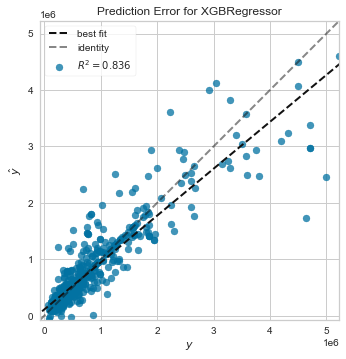

In [39]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(best_xgb_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
visualizer.show()            

Tester le modèle avec des données inventées

In [40]:
test = pd.read_csv("./test.csv")
test.head()

,f0,f1,f2,f3,f4,f5
0,1,275,728,8,4,230.00
1,0,281,224,4,2,75.49
2,0,161,257,4,3,100.18
3,1,225,349,5,2,115.00


In [41]:
X_test = np.asarray(test)

In [42]:
X_test = standard_x.fit_transform(X_test)

In [43]:
predictions = loaded_model.predict(X_test)
predictions

array([1429179.6 ,  189929.67,  487805.72,  164787.19], dtype=float32)

In [44]:
import xgboost as xgb

xgb.__version__

'0.90'

In [45]:
pd.__version__

'0.23.4'

In [46]:
import numpy as np
np.__version__

'1.16.2'

In [47]:
import sklearn
sklearn.__version__

'0.22.2.post1'